### Syllabification Notebook
- This notebook takes WAV datasets generated by `1.0-segment-song-from-wavs` and segments the WAVs into spectrograms of syllables 
  - WAVs are expected to be in this format: `2017-04-16_17-27-44-760000.wav`
- The notebook outputs and HDF5 file which contains metadata about who the individual is, when the syllable was sung, how long the syllable is, which file the syllable comes from

### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import pandas as pd
from datetime import datetime, timedelta
import os
import sys
import IPython.display
import pickle
from sklearn.externals.joblib import Parallel, delayed
from PIL import Image

import warnings 
warnings.filterwarnings('ignore')

In [3]:
from avgn.segment_song.preprocessing import *
import avgn.segment_song.wav_to_syllables as w2s
import avgn.spectrogramming.spectrogramming as sg

### Parameters for segmenting syllables

In [4]:
syll_size = 128
hparams = {
    'species':'BF',
    # filtering
    'highcut':15000,
    'lowcut':500,
    
    # spectrograms
    'mel_filter': True, # should a mel filter be used?
    'num_mels':syll_size, # how many channels to use in the mel-spectrogram
    'num_freq':512, # how many channels to use in a spectrogram 
    'num_freq_final': syll_size, # how many channels to use in the resized spectrogram
    'sample_rate':44100, # what rate are your WAVs sampled at?
    'preemphasis':0.97, 
    'min_silence_for_spec': 0.5, #minimum length of silence for a spectrogram to be considered a good spectrogram
    'frame_shift_ms':0.5, # step size for fft
    'frame_length_ms':6, # frame length for fft
    'min_level_db':-95, # minimum threshold db for computing spe 
    'spec_thresh_min': -40, # (db)
    'spec_thresh_delta': 5, # (db) what 
    'ref_level_db':20, # reference db for computing spec
    'sample_rate':44100, # sample rate of your data
    'fmin': 300, # low frequency cutoff for mel filter
    'fmax': None, # high frequency cutoff for mel filter
    
    # Vocal Envelope
    'smoothing' : 'gaussian', # 'none', 
    'envelope_signal' : "spectrogram", # spectrogram or waveform, what to get the vocal envelope from
    'gauss_sigma_s': .0001,
    'FOI_min': 4, # minimum frequency of interest for vocal envelope (in terms of mel)
    'FOI_max': 24, # maximum frequency of interest for vocal envelope (in terms of mel)
    
    # Silence Thresholding
    'silence_threshold' : 0, # normalized threshold for silence
    'min_len' : 5., # minimum length for a vocalization (fft frames)
    'power_thresh': .3, # Threshold for which a syllable is considered to be quiet weak and is probably noise

    # Syllabification
    'min_syll_len_s' : 0.03, # minimum length for a syllable
    'segmentation_rate': 0.0,#0.125, # rate at which to dynamically raise the segmentation threshold (ensure short syllables)
    'threshold_max': 0.25,
    'min_num_sylls': 20, # min number of syllables to be considered a bout
    'slow_threshold':0.0,#0.02, # second slower threshold
    'max_size_syll': syll_size, # the size of the syllable
    'resize_samp_fr': int(syll_size*5.0), # (frames/s) the framerate of the syllable (in compressed spectrogram time components)
    
    # Sencond pass syllabification
    'second_pass_threshold_repeats':50, # the number of times to repeat the second pass threshold
    'ebr_min': 0.05, # expected syllabic rate (/s) low 
    'ebr_max':  0.2, # expected syllabic rate (/s) high 
    'max_thresh':  0.02, # maximum pct of syllabic envelope to threshold at in second pass
    'thresh_delta':  0.005, # delta change in threshold to match second pass syllabification
    'slow_threshold': 0.005, # starting threshold for second pass syllabification
    
    'pad_length' : syll_size, # length to pad spectrograms to 
    
    # spectrogram inversion
    'max_iters':200,
    'griffin_lim_iters':60,
    'power':1.5,

    # Thresholding out noise
    'mel_noise_filt' : 0.15, # thresholds out low power noise in the spectrum - higher numbers will diminish inversion quality
}
globals().update(hparams)
now_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S") # this is used to identify this training instance
# save the dictionary so that we can reload it for recovering waveforms
dict_save = '../../../data/parameter_dictionaries/'+now_string+'_dict.pickle'
with open(dict_save, 'wb') as f:
    pickle.dump(hparams, f, protocol=pickle.HIGHEST_PROTOCOL)
print(dict_save)

../../../data/parameter_dictionaries/2018-10-22_17-38-08_dict.pickle


## Visualize the syllable segmentation algorithm on an example WAV file

In [5]:
wav_loc = '../../../data/bf_wav/Bird0/wavs/1900-03-03_00-00-00-000000.wav'

In [6]:
# read in the data
csv_loc = '/'.join(wav_loc.split('/')[:-2] + ['csv'] + [wav_loc.split('/')[-1][:-4] + '.csv'])
rate, data= wavfile.read(wav_loc)
(bird,original_wav, start_time) = pd.read_csv(csv_loc, header=None).values[0]
start_time = datetime.strptime(start_time, "%Y-%m-%d_%H-%M-%S-%f")

In [7]:
# bandpass filter data
data = butter_bandpass_filter(data, lowcut, highcut, rate, order=2).astype('float32')

In [8]:
print('Rate: ', rate, 'Time sung: ',start_time, 'Length:', len(data)/float(rate))

Rate:  32000 Time sung:  1900-03-03 00:00:00 Length: 11.60896875


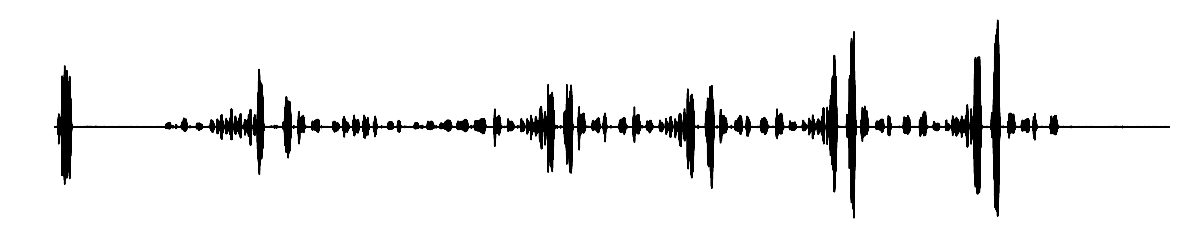

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(data, color='black')
ax.set_xlim((0, len(data)))
ax.axis('off')
plt.show()

In [10]:
# play back a sample of the song
IPython.display.Audio(data=data[:rate*10], rate=44100)

### Generate Spectrograms and vocal envelope

In [11]:
_mel_basis = sg._build_mel_basis(hparams) # build a basis function if you are using a mel spectrogram
# Generates the spectrogram and also thresholds out bad spectrograms (e.g. too noisy) - take a look at wav_to_syllables.py to determine if you want this
spec, vocal_envelope, cur_spec_thresh, fft_time_idx, fft_rate = w2s.compute_spec_and_env((data/32768.).astype('float32'), start_time, hparams, rate, _mel_basis, verbose = True, mel_filter=mel_filter)

-95 -40


<Figure size 432x288 with 0 Axes>

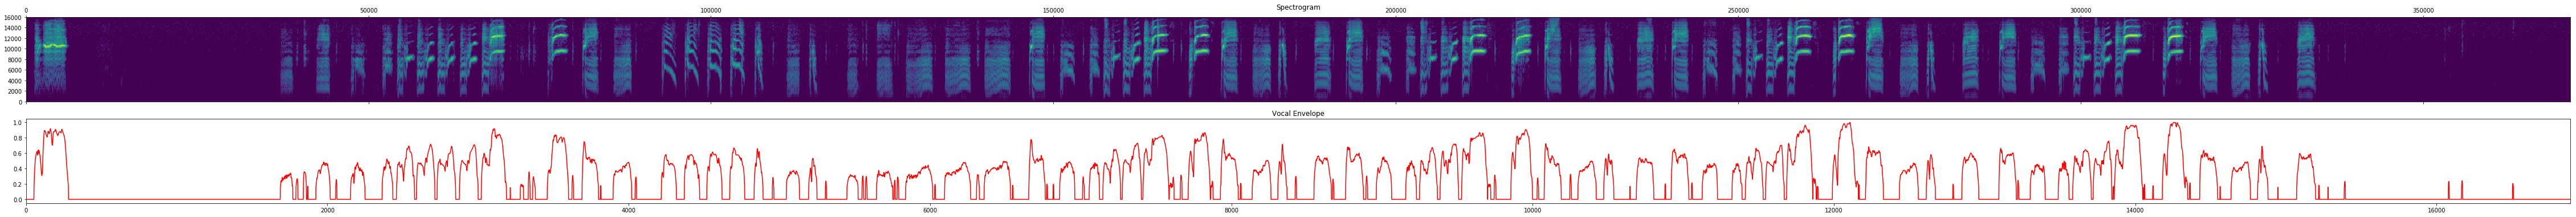

In [12]:
# visualize the generated spectrogram
plt.clf()
start_time = fft_time_idx[0]
stop_time = fft_time_idx[-1]
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(80,6))

ax[0].matshow(spec, interpolation=None, aspect='auto', # cmap=plt.cm.gray_r,
                 cmap=plt.cm.viridis, origin='lower', extent=[start_time,stop_time,0,rate/2])
ax[0].set_title('Spectrogram')

ax[1].plot(vocal_envelope, color = 'red')
ax[1].set_xlim([0,len(vocal_envelope)])
ax[1].set_title('Vocal Envelope')
plt.show()

In [13]:
# Output some stats of our file
print(''.join(['new Spectrogram Size: ',str(np.shape(spec))]))
print(''.join(['Original Waveform Size: ',str(np.shape(data))]))
print(''.join(['Length (s): ', str(len(data)/float(rate))]))
print(''.join(['Original Sampling Rate (ms) : ', str(1./float(rate))]))
print(''.join(['New Sampling Rate (ms): ', str(round((len(data)/float(rate))*1000 / float(np.shape(spec)[1]), 3))]))

new Spectrogram Size: (128, 16886)
Original Waveform Size: (371487,)
Length (s): 11.60896875
Original Sampling Rate (ms) : 3.125e-05
New Sampling Rate (ms): 0.687


### Syllabification: detect onsets and offsets of noise/vocalization

In [14]:
# Detect onsets and offsets of vocal envelope
#vocal_envelope =np.mean(norm(wav_spectrogram.T), axis =0)
#vocal_envelope = norm(np.sum(spec, axis = 0))
onsets, offsets = detect_onsets_offsets(vocal_envelope, 
      threshold = silence_threshold,
      min_distance = 0.
     )

print(onsets[0:10], offsets[0:10], len(onsets))

[52, 1687, 1791, 1840, 1867, 1923, 2055, 2154, 2363, 2458] [283, 1772, 1806, 1862, 1873, 2020, 2065, 2251, 2436, 2580] 121


In [15]:
new_fft_rate = len(data)/rate/float(np.shape(spec)[1])
for i in range(second_pass_threshold_repeats):
    onsets, offsets = w2s.second_pass_threshold(onsets, offsets, vocal_envelope,new_fft_rate, hparams)
    #print(len(onsets))

## Syllabification

In [16]:
# segment into syllables based upon onset/offsets
all_syllables, all_syllables_time_idx, syll_start = w2s.cut_syllables(onsets, offsets, spec, fft_time_idx, hparams)
# Timing for when each syllable started (seconds)
print(syll_start[0:5])

[1143.9846026293972, 37113.50047376525, 39401.46967902404, 40479.45516996329, 41073.447175174704]


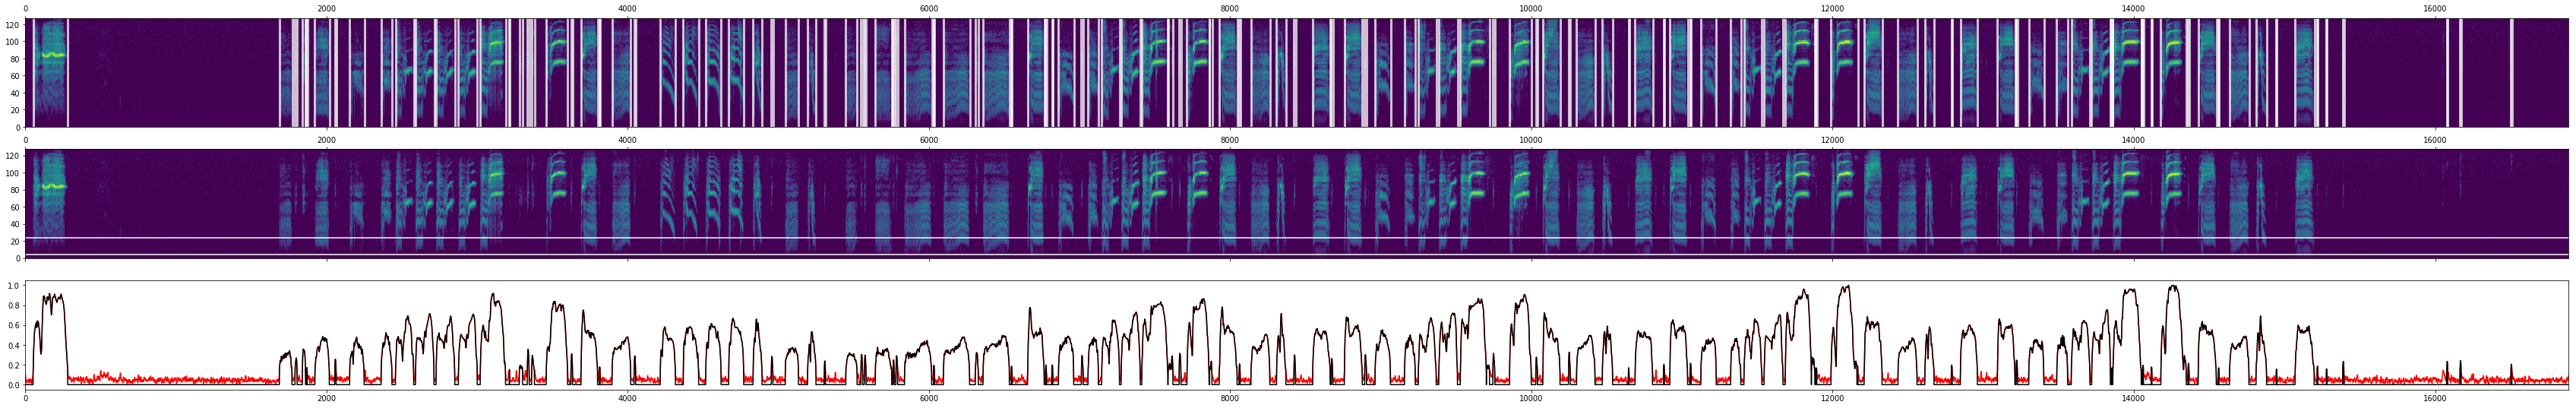

In [17]:
w2s.plot_seg_spec(np.concatenate(np.array((onsets,offsets))), spec, fft_time_idx, vocal_envelope, 0, hparams)  

In [18]:
syllable_lengths = [np.shape(all_syllables[i])[1]/fft_rate for i in range(len(all_syllables))]
print(len(syllable_lengths))

115


0.004124944480634846 0.15881036250444155 0.05239875126487598
[0.15881036250444155, 0.05843671347566032, 0.010312361201587114, 0.015124796428994435, 0.004124944480634846]


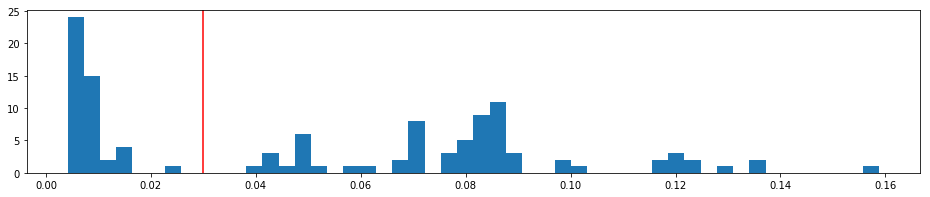

In [19]:
# Plot how we've thresholded out syllables which are too short to be considered song
print(np.min(syllable_lengths), np.max(syllable_lengths), np.mean(syllable_lengths))
print(syllable_lengths[0:5])
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,3))
_ = plt.hist(syllable_lengths,bins=50)
ax.axvline(x=hparams['min_syll_len_s'], color = 'red')
plt.show()

In [20]:
# remove short syllables
all_syllables, all_syllables_time_idx, syll_start = w2s.threshold_syllables(all_syllables, all_syllables_time_idx, syll_start, min_syll_len_s, fft_rate, power_thresh = power_thresh)

#### Test spectral reconstruction on syllable

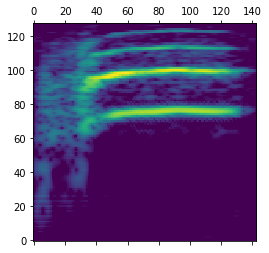

(128, 143)


In [21]:
syll_num = 10
syll = all_syllables[syll_num]
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(4,4))
ax.matshow(syll, origin='lower', aspect='auto')
plt.show()
print(np.shape(all_syllables[syll_num]))

In [22]:
mel_inversion_filter = (_mel_basis.T / _mel_basis.sum(axis=1))
mel_inversion_filter =np.nan_to_num(np.transpose(mel_inversion_filter / mel_inversion_filter.sum(axis=1)[:, np.newaxis]))

In [23]:
# original wav
IPython.display.Audio(data=data[int(all_syllables_time_idx[syll_num][0]):int(all_syllables_time_idx[syll_num][-1])], rate=44100)

In [24]:
if mel_filter: 
    syll = np.dot(syll.T, mel_inversion_filter).T

In [25]:
def rescale(X, out_min, out_max):
    return out_min + (X - np.min(X)) * ((out_max - out_min) / (np.max(X) - np.min(X)))

In [26]:
### adding some noise tends to improve reconstruction quality
syll = rescale(syll, 0,1) +np.reshape(np.random.rand(np.prod(np.shape(syll)))*.25, np.shape(syll))

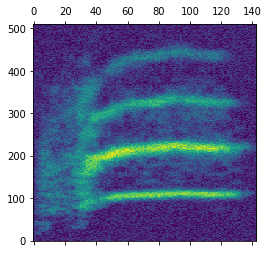

(512, 143)


In [27]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(4,4))
ax.matshow(syll, origin='lower', aspect='auto')
plt.show()
print(np.shape(syll))

In [28]:
# test spectrogram inversion
waveform = sg.inv_spectrogram(rescale(syll,.5,1), hparams)

In [29]:
# play back a sample of the song
IPython.display.Audio(data=waveform, rate=44100)

### Resize and Pad Spectrograms

In [30]:
import copy

In [31]:
all_syllables_comp = copy.deepcopy(all_syllables)

In [32]:
def sub_mode(syll):
    freqs, bins = np.histogram(syll, bins = 100)
    syll = syll - bins[np.argsort(freqs)][-1]#np.median(syll)#
    syll[syll <0] = 0
    return syll

In [33]:
# resize spectrogram
all_syllables_comp = w2s.resize_spectrograms(all_syllables_comp, max_size = max_size_syll, resize_samp_fr = resize_samp_fr, fft_rate = fft_rate, n_freq= num_freq_final, pad_length=pad_length)

In [34]:
# set mode to 0
#all_syllables_comp = [sub_mode(syll) for syll in all_syllables_comp]

In [35]:

# set mode to 0
all_syllables_comp = [sub_mode(syll) for syll in all_syllables_comp]

# 0 pade
all_syllables_comp = np.array([w2s.pad_spectrogram(i, pad_length) for i in all_syllables_comp])
all_syllables_comp = [(norm(i)*255).astype('uint8') for i in all_syllables_comp]

#### Test spectral reconstruction on syllable

In [36]:
syll = all_syllables_comp[syll_num]

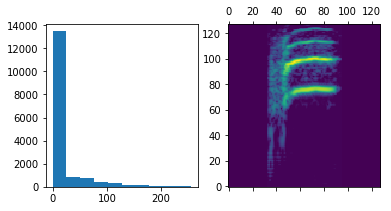

In [37]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(6,3))
_ = ax[0].hist(syll.flatten())
ax[1].matshow(norm(syll.astype('float32')), origin='lower', aspect='auto')
plt.show()

In [38]:
# remove edges
syll_mean = np.mean(syll, axis=0)
if syll_mean[0] == syll_mean[-1]:
    sb = [i for i in np.arange(1, len(syll_mean)) if (syll_mean[i] == syll_mean[0]) and (syll_mean[i-1] == syll_mean[0])]
    sb = [i for i in sb if i+1 not in sb][0], [i for i in sb if i-1 not in sb][-1]
    syll = syll[:,sb[0]+1:sb[1]-1]  

In [39]:
if mel_filter:
    resize_shape = (int((np.shape(syll)[1]/hparams['resize_samp_fr']) * (1000/hparams['frame_shift_ms'])), hparams['num_freq_final'])
    syll = np.array(Image.fromarray(np.squeeze(syll)).resize(resize_shape, Image.ANTIALIAS))
    syll = np.dot(syll.T, mel_inversion_filter).T
else:
    resize_shape = (int((np.shape(syll)[1]/hparams['resize_samp_fr']) * (1000/hparams['frame_shift_ms'])), hparams['num_freq'])
    syll = np.array(Image.fromarray(np.squeeze(syll)).resize(resize_shape, Image.ANTIALIAS))

In [40]:
### adding some noise tends to improve reconstruction quality
syll = rescale(syll, .25,1) +np.reshape(np.random.rand(np.prod(np.shape(syll)))*.25, np.shape(syll))

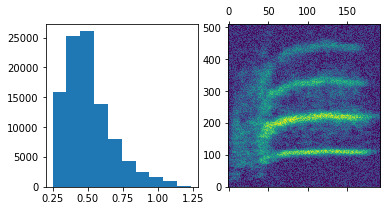

In [41]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(6,3))
_ = ax[0].hist(syll.flatten())
ax[1].matshow(norm(syll.astype('float32')), origin='lower', aspect='auto')
plt.show()

In [42]:
# test spectrogram inversion
waveform = sg.inv_spectrogram(rescale(syll, .5,1), hparams)

In [43]:
# play back a sample of the song
IPython.display.Audio(data=waveform, rate=44100)

### Plot computed syllables

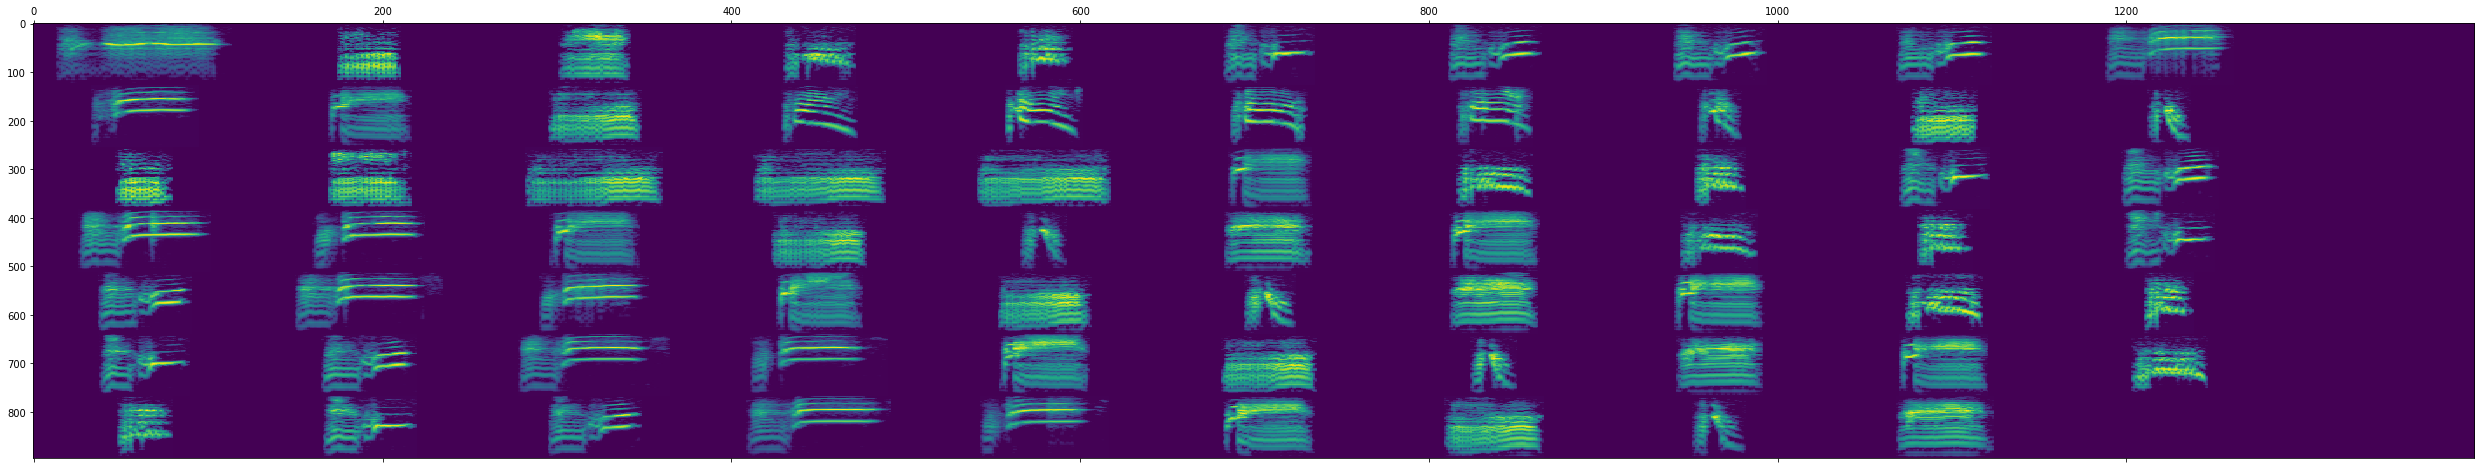

In [44]:
w2s.plt_all_syllables(all_syllables_comp, num_freq_final,  max_rows = 8, max_sylls = 100, width = 1400)
plt.show()

<Figure size 432x288 with 0 Axes>

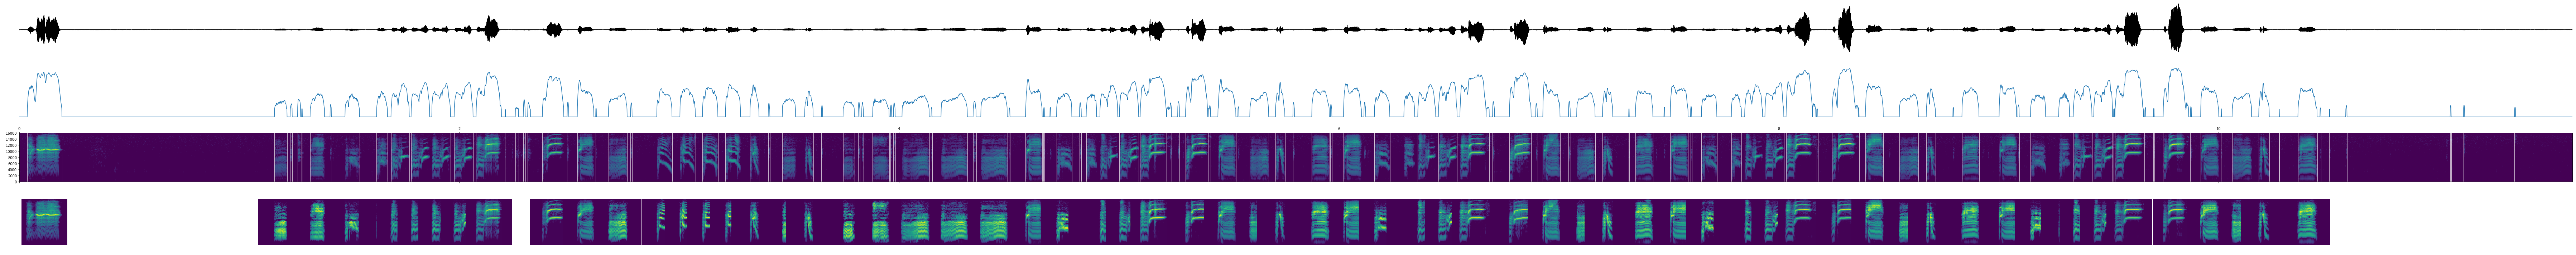

In [45]:
# This takes a while to run... we're visualizing the whole pipeline on this song
w2s.plot_pipeline(data, vocal_envelope,spec.T,onsets,offsets, all_syllables_comp,rate,all_syllables_time_idx,syllable_lengths, figsize = (100,10))

## Processing data

#### Run through in parallel

In [46]:
# find the data bird folders
dataset_location = '../../../data/bf_wav/*'
bird_folders = glob(dataset_location)
bird_folders

['../../../data/bf_wav/Bird5',
 '../../../data/bf_wav/Bird8',
 '../../../data/bf_wav/Bird2',
 '../../../data/bf_wav/Bird6',
 '../../../data/bf_wav/Bird1',
 '../../../data/bf_wav/Bird3',
 '../../../data/bf_wav/Bird9',
 '../../../data/bf_wav/Bird10',
 '../../../data/bf_wav/Bird4',
 '../../../data/bf_wav/Bird0',
 '../../../data/bf_wav/Bird7']

In [47]:
data_output_location = '../../../data/bf_song_syllables/'

In [48]:
skip_existing = False # skip already segmented birds 
parallel = True # run through WAVs in parallel
n_jobs = 10 # how many threads to use if parallel is true
verbosity = 5 # how verbose to make the output of the parallelization (higher = more, 0 = none, >50 output is sent to std.out)
nex = 10 # how many example wavs to plot
save=True
visualize = False # visualize the output of the algorithm for optimizing parameters
if visualize==True: 
    save=False

In [68]:
import hdbscan 
from skimage.transform import resize
import umap
import time 
import seaborn as sns

def plot_with_labels(data, labels, title = '', ax = None, figsize = (9,9)):
    palette = sns.color_palette('husl', len(np.unique(labels)))
    labs_to_numbers_dict = {l:i for i,l in enumerate(np.unique(labels))}
    np.random.shuffle(palette)
    colors = [palette[labs_to_numbers_dict[x]] if x >= 0 else (0.75, 0.75, 0.75) for x in np.array(labels)]

    if not ax: fig, ax= plt.subplots(nrows=1,ncols=1,figsize=figsize)
    ax.scatter(data.T[0], data.T[1],
               color=colors, alpha = 1, linewidth= 0, s=5)
    ax.axis('off')
    ax.set_title(title)
    if not ax: plt.show()
        
def cluster_data(data, algorithm, args, kwds, verbose = True):
    """ Cluster data using arbitrary clustering algoritm in sklearn
    """
    # Function modified from HDBSCAN python package website
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    if verbose: print('Clustering took {:.2f} s'.format(end_time - start_time))
    return labels

Bird5
Bird5 208


[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   25.9s
[Parallel(n_jobs=10)]: Done 208 out of 208 | elapsed:   37.9s finished


len dataset:  15995


Clustering took 0.16 s


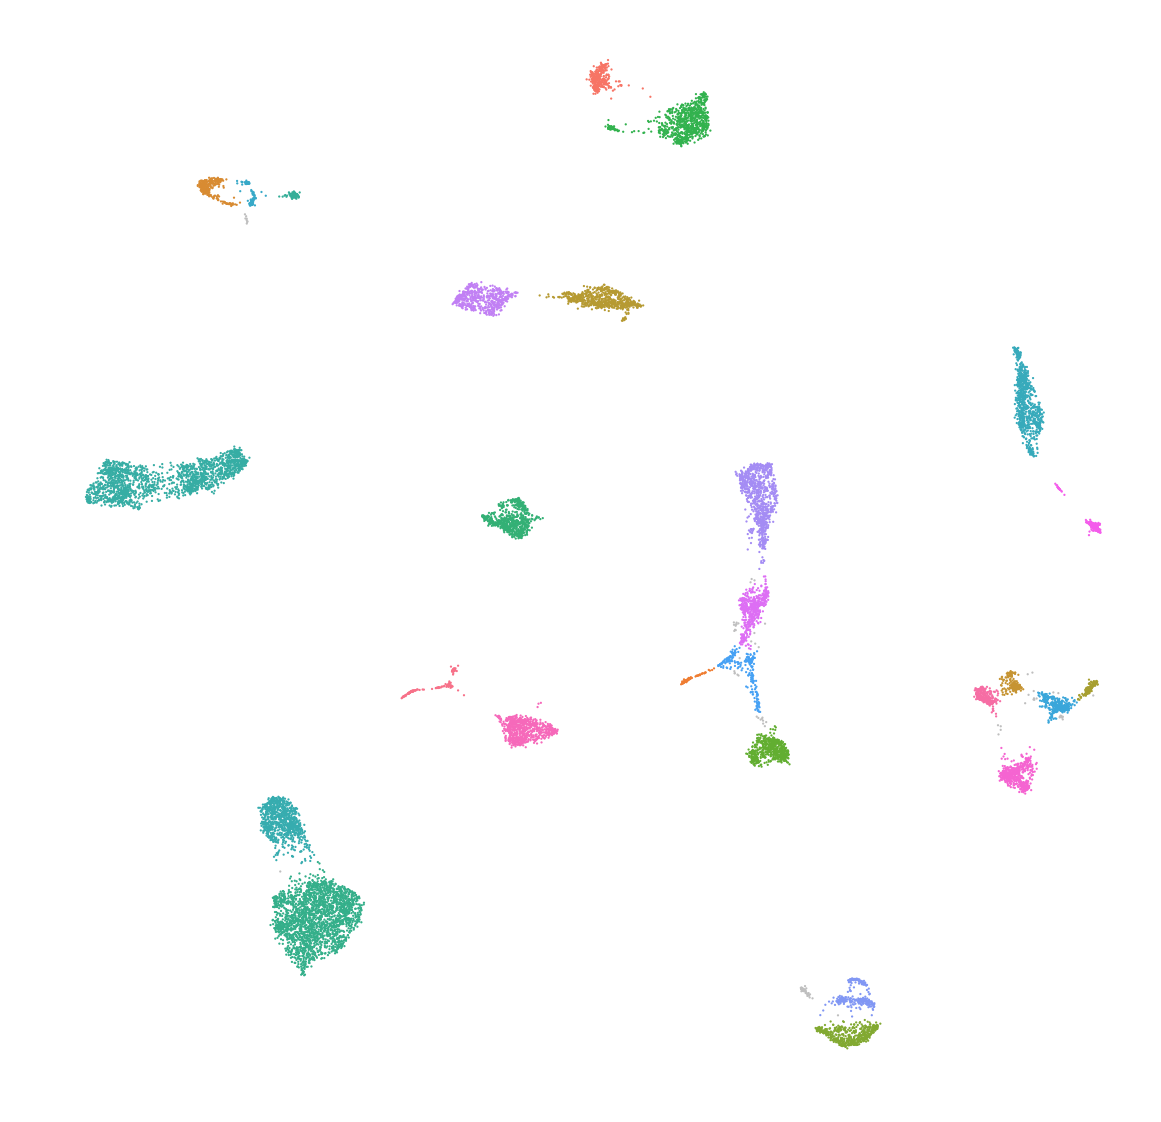

Saving dataset to  ../../../data/bf_song_syllables/BF/Bird5_128.hdf5
Bird8
Bird8 26


[Parallel(n_jobs=10)]: Done  13 out of  26 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=10)]: Done  19 out of  26 | elapsed:    5.0s remaining:    1.8s


len dataset:  1966


[Parallel(n_jobs=10)]: Done  26 out of  26 | elapsed:    5.9s finished


Clustering took 0.02 s


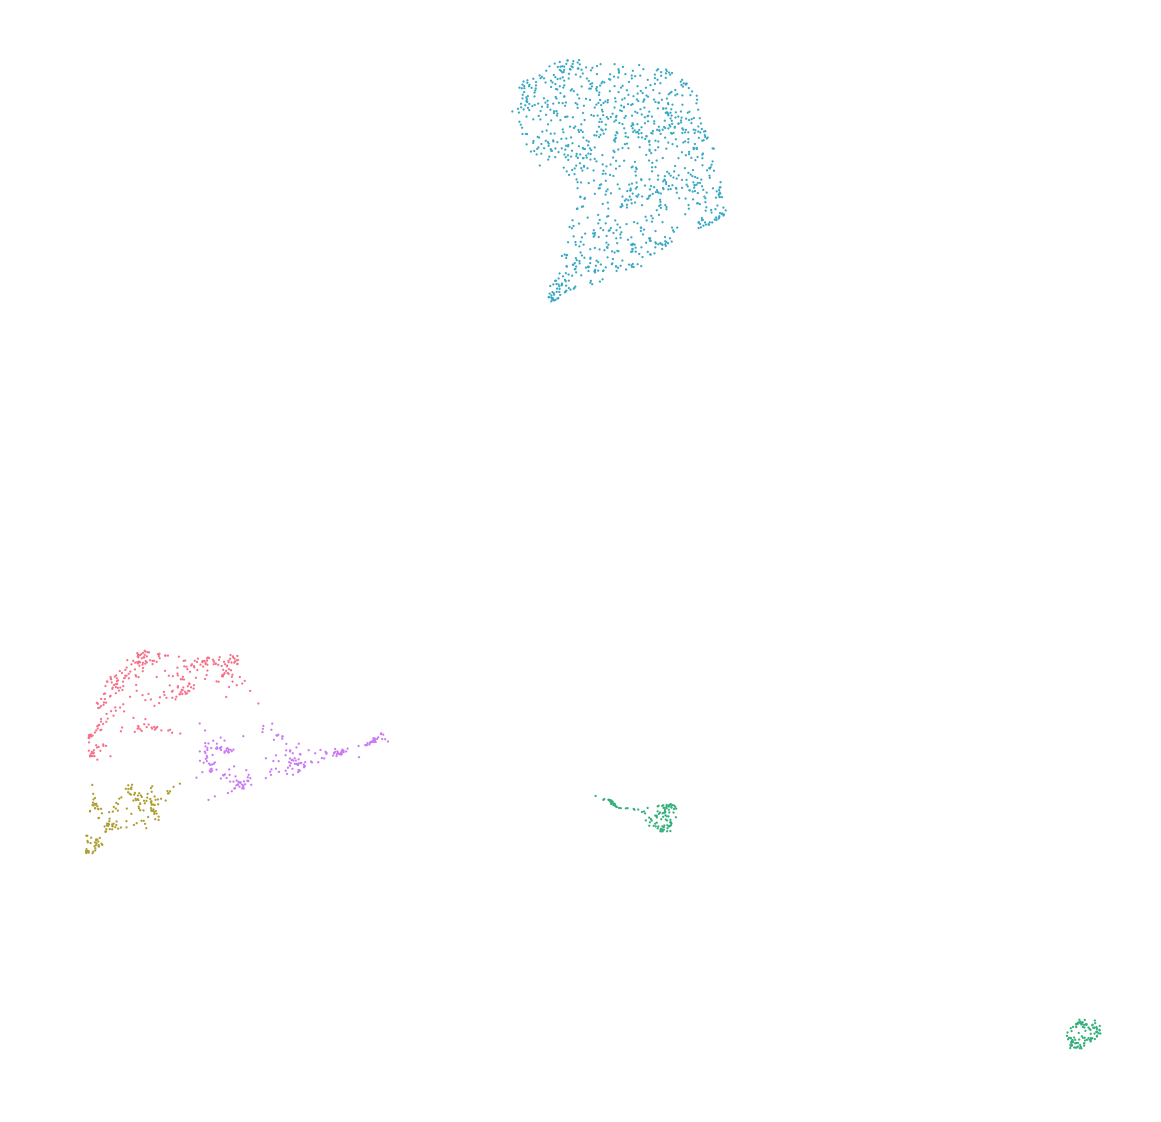

Saving dataset to  ../../../data/bf_song_syllables/BF/Bird8_128.hdf5
Bird2
Bird2 251


[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   48.5s
[Parallel(n_jobs=10)]: Done 251 out of 251 | elapsed:  1.6min finished


len dataset:  23303


Clustering took 0.55 s


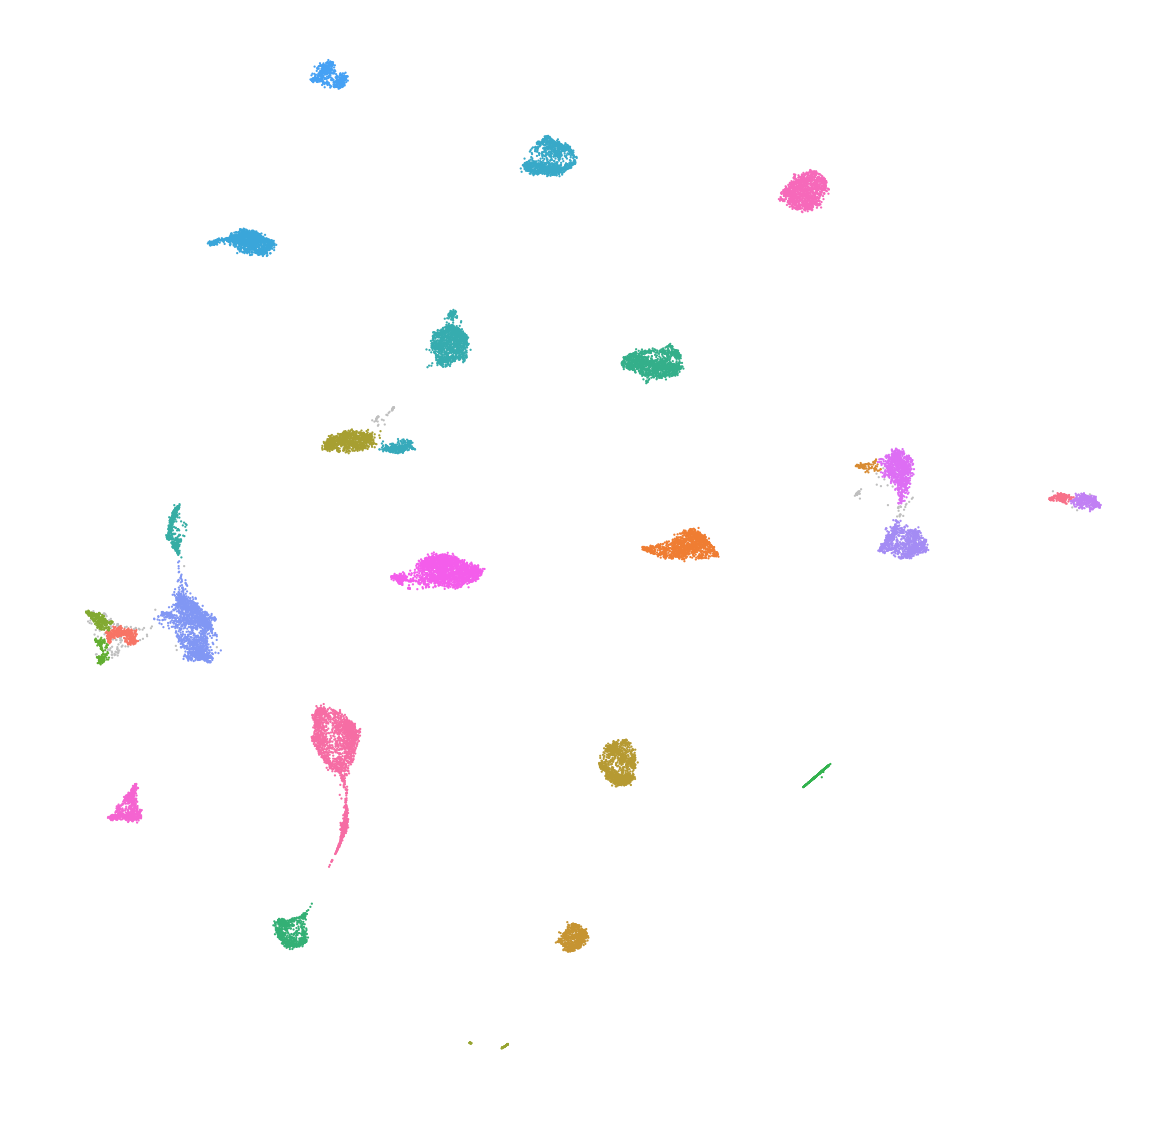

Saving dataset to  ../../../data/bf_song_syllables/BF/Bird2_128.hdf5
Bird6
Bird6 149


[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   26.6s
[Parallel(n_jobs=10)]: Done 149 out of 149 | elapsed:  1.2min finished


len dataset:  12165


Clustering took 0.31 s


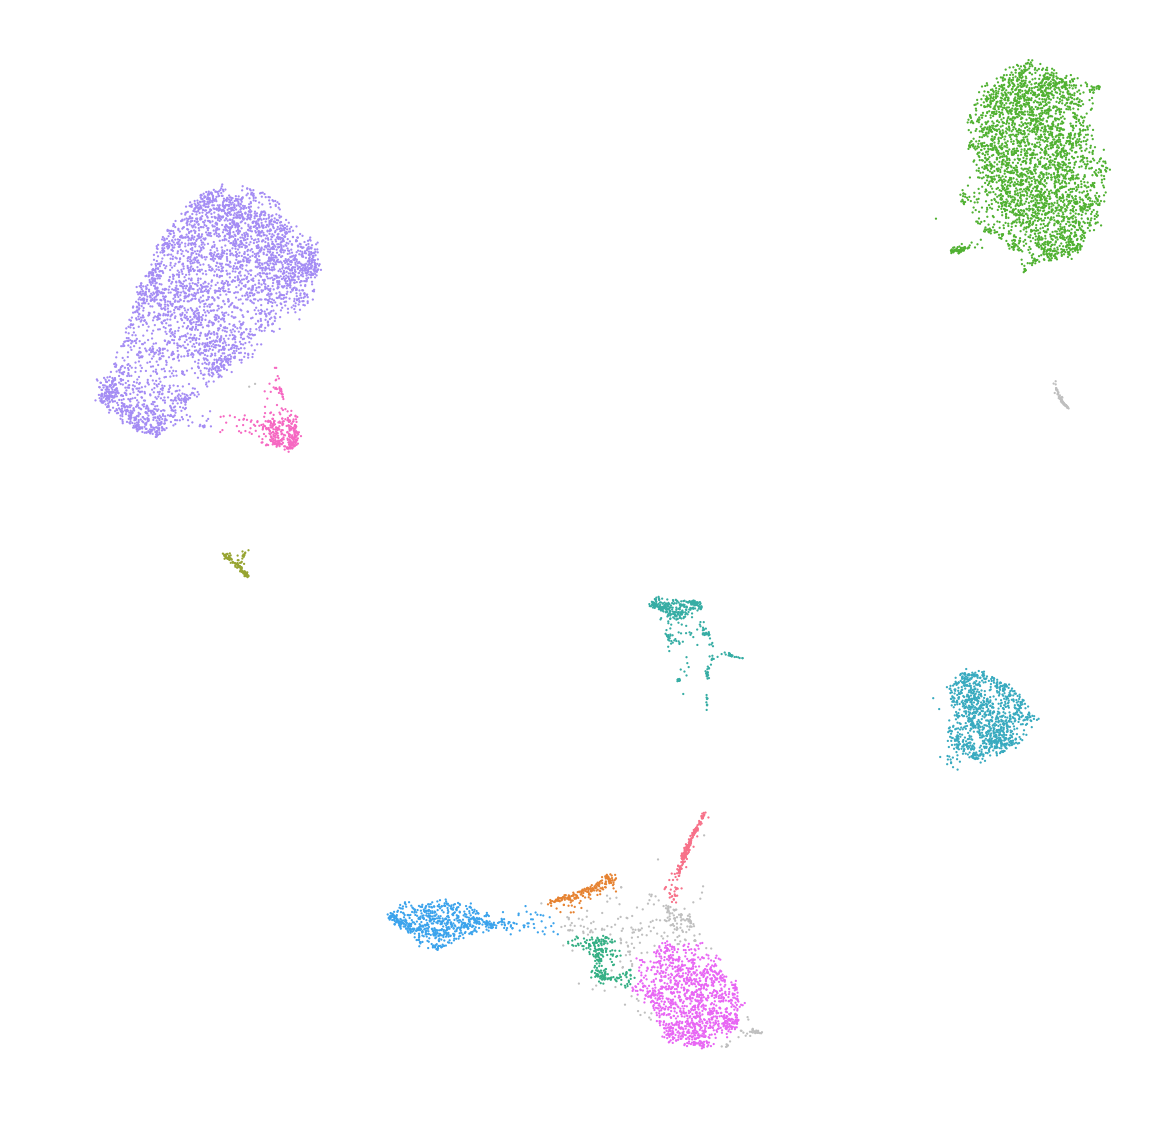

Saving dataset to  ../../../data/bf_song_syllables/BF/Bird6_128.hdf5
Bird1
Bird1 15


[Parallel(n_jobs=10)]: Done   4 out of  15 | elapsed:   13.5s remaining:   37.2s
[Parallel(n_jobs=10)]: Done   8 out of  15 | elapsed:   16.1s remaining:   14.1s
[Parallel(n_jobs=10)]: Done  12 out of  15 | elapsed:   21.8s remaining:    5.4s
[Parallel(n_jobs=10)]: Done  15 out of  15 | elapsed:   25.5s finished


len dataset:  1623


Clustering took 0.03 s


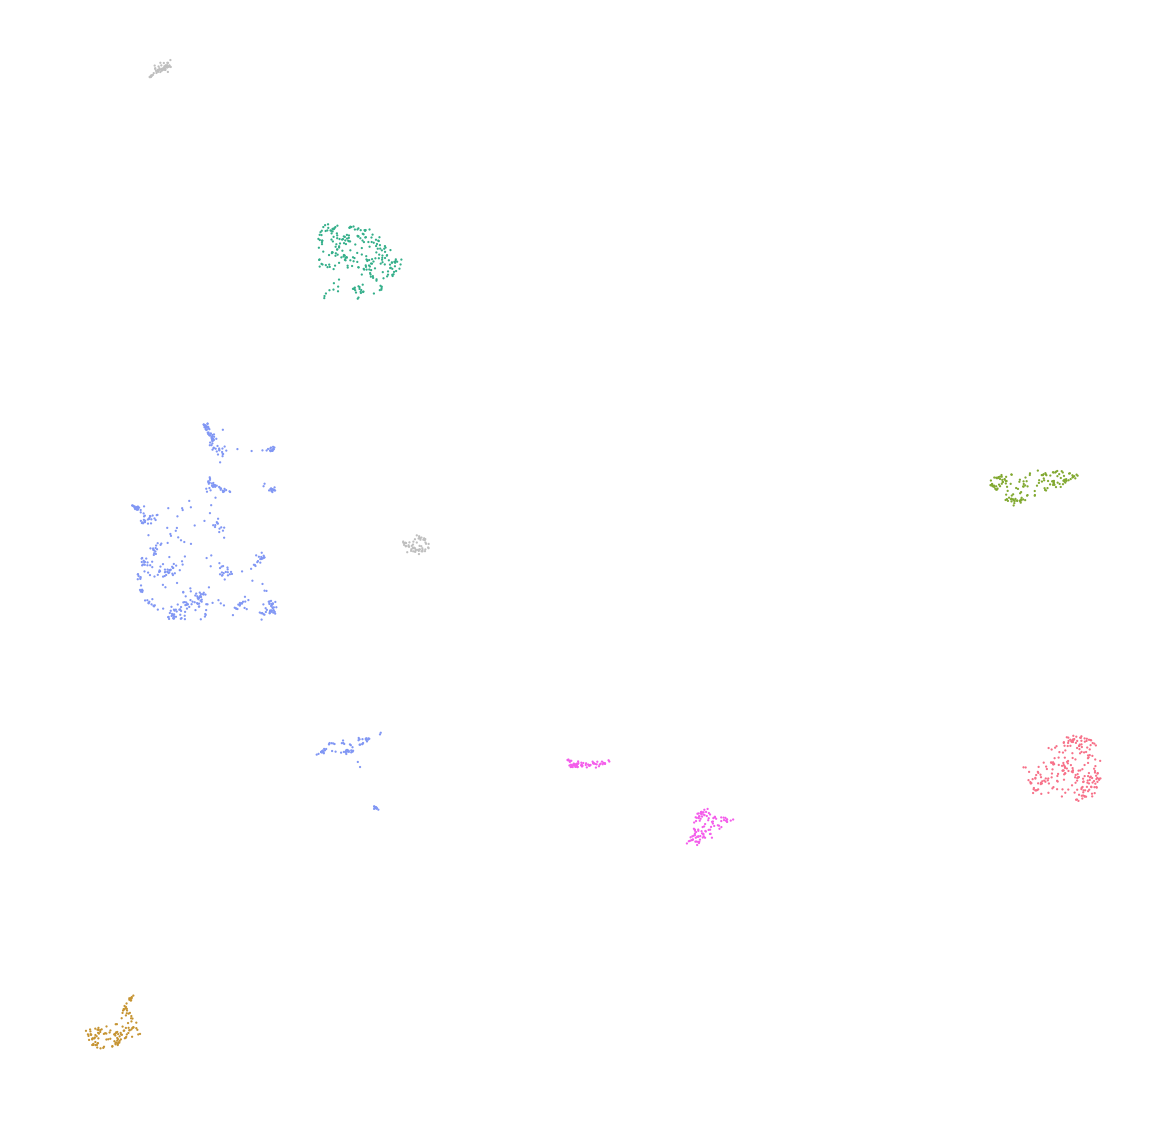

Saving dataset to  ../../../data/bf_song_syllables/BF/Bird1_128.hdf5
Bird3
Bird3 7


[Parallel(n_jobs=10)]: Done   2 out of   7 | elapsed:    3.6s remaining:    9.0s
[Parallel(n_jobs=10)]: Done   4 out of   7 | elapsed:    4.0s remaining:    3.0s
[Parallel(n_jobs=10)]: Done   7 out of   7 | elapsed:    6.6s finished


len dataset:  766


Clustering took 0.01 s


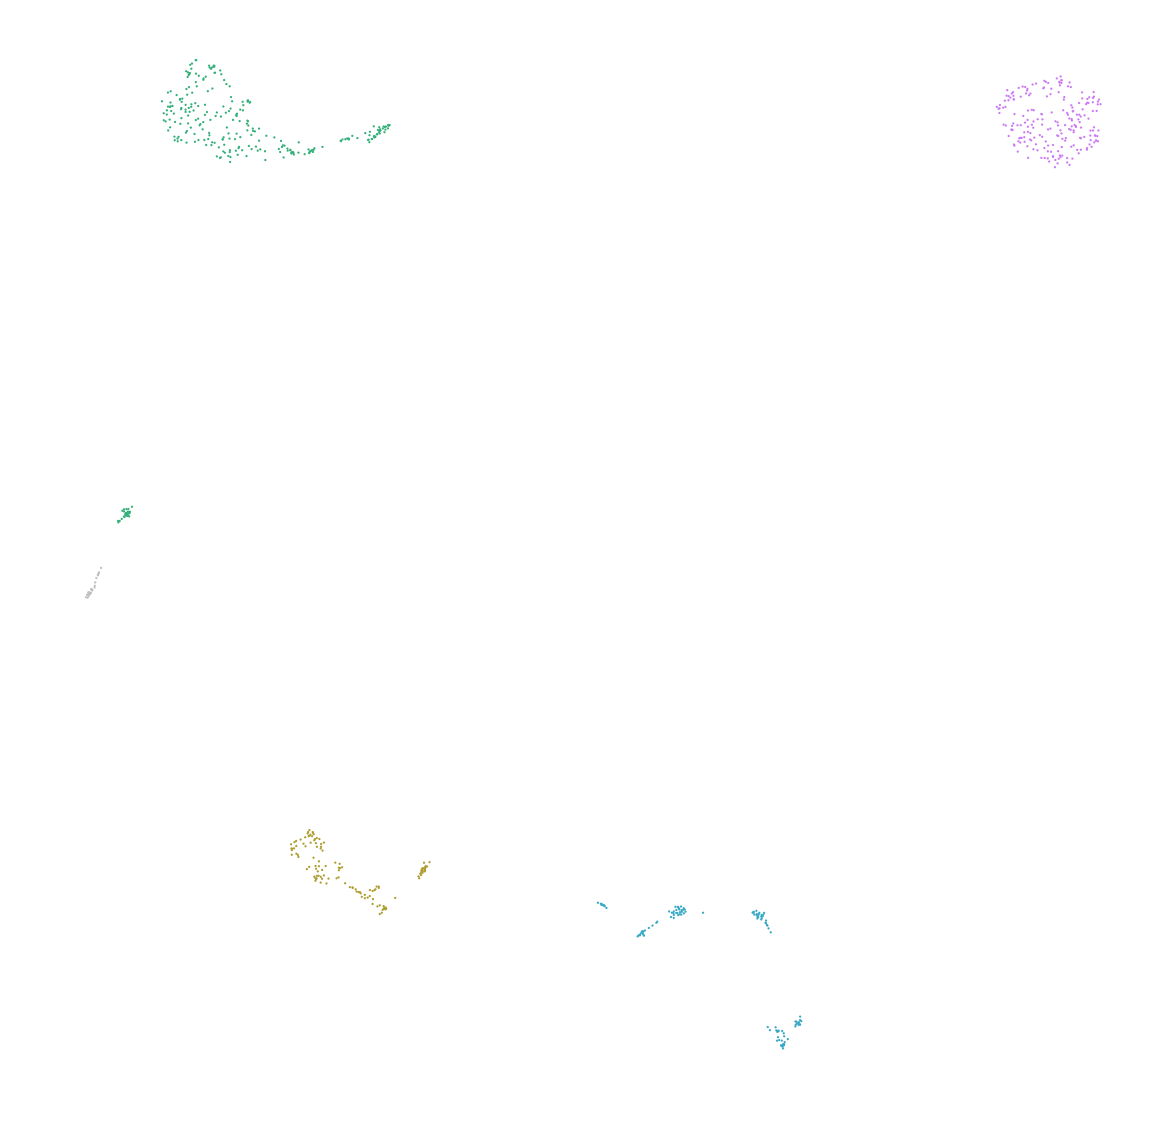

Saving dataset to  ../../../data/bf_song_syllables/BF/Bird3_128.hdf5
Bird9
Bird9 163


[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   48.5s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 163 out of 163 | elapsed:  2.3min finished


len dataset:  15492


Clustering took 0.33 s


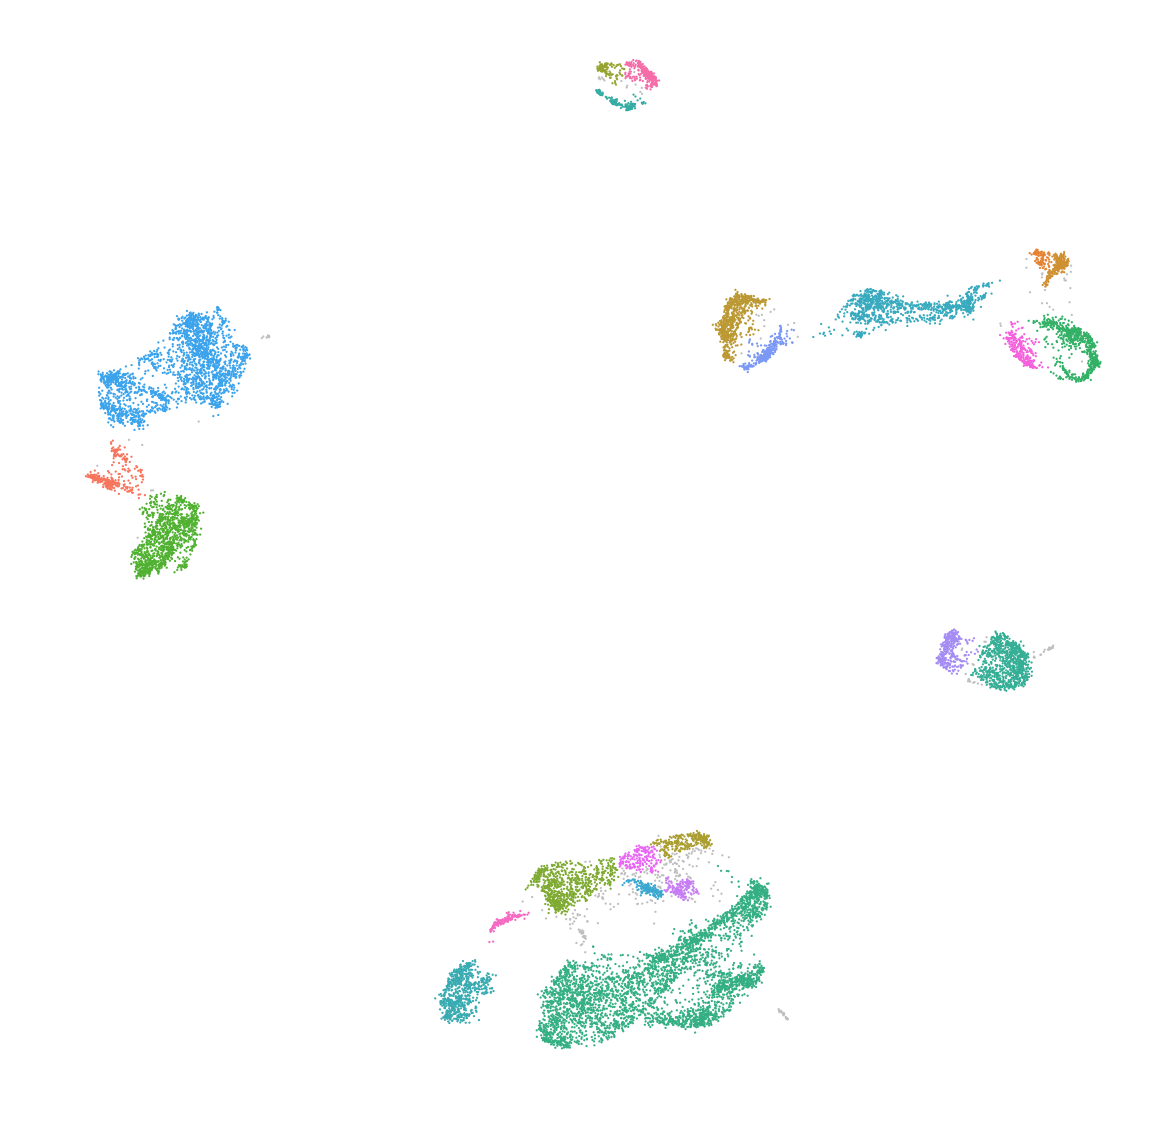

Saving dataset to  ../../../data/bf_song_syllables/BF/Bird9_128.hdf5
Bird10
Bird10 61


[Parallel(n_jobs=10)]: Done  55 out of  61 | elapsed:   20.9s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  61 out of  61 | elapsed:   22.6s finished


len dataset:  4495


Clustering took 0.04 s


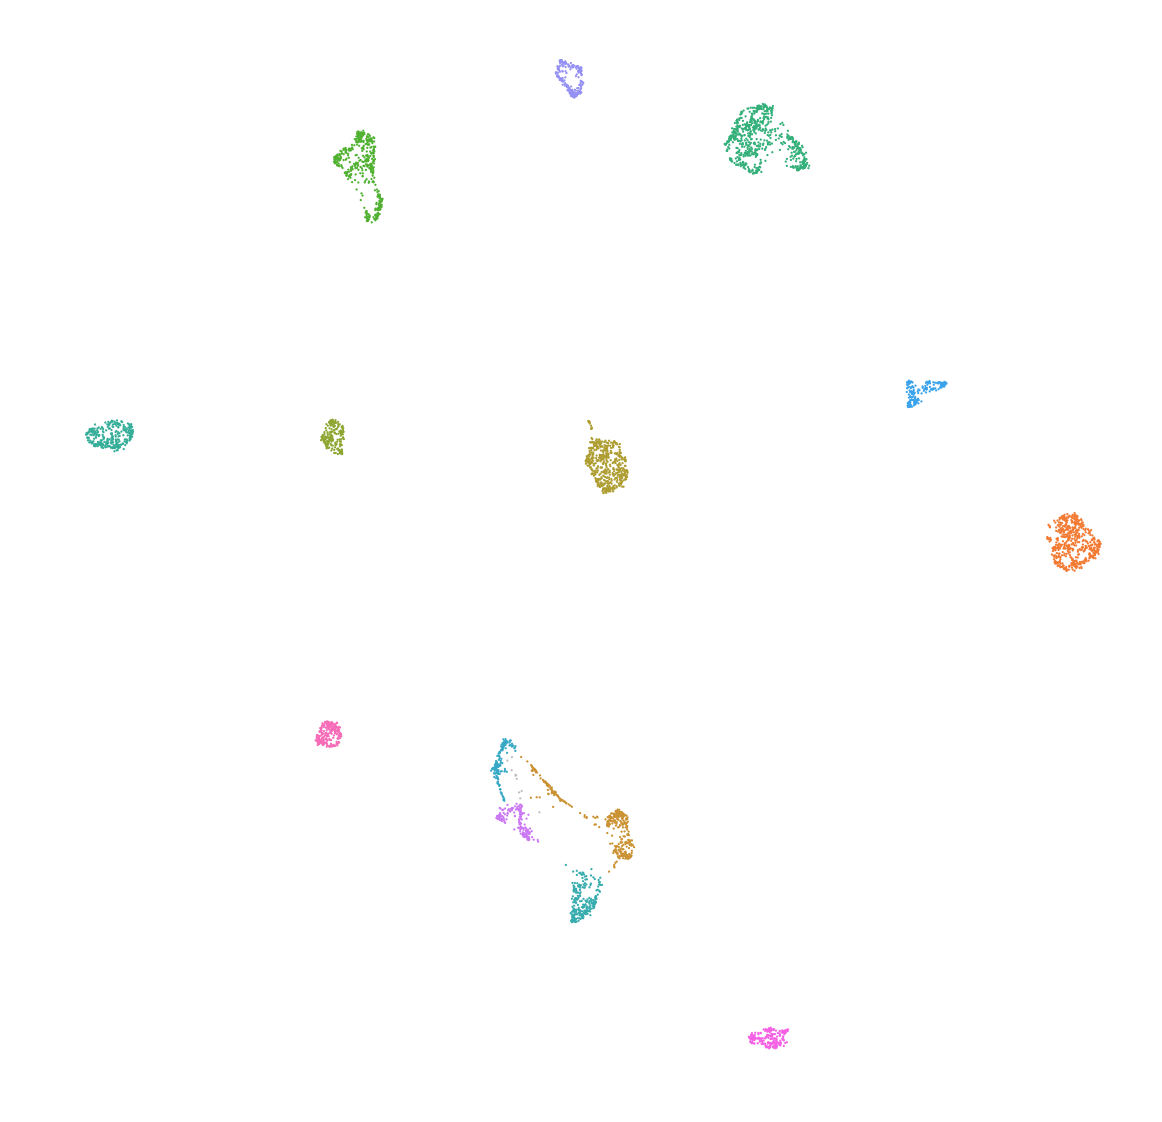

Saving dataset to  ../../../data/bf_song_syllables/BF/Bird10_128.hdf5
Bird4
Bird4 217


In [ ]:
key_list = (
            'all_bird_wav_file', # Wav file (bout_raw) that the syllable came from
            'all_bird_syll', # spectrogram of syllable
            'all_bird_syll_start', # time that this syllable occured
            'all_bird_t_rel_to_file', # time relative to bout file that this 
            'all_bird_syll_lengths' # length of the syllable
           ) 

for bird_folder in tqdm(bird_folders):
    bird_name = bird_folder.split('/')[-1]
    print(bird_name)

    # prepare the data folder
    if not os.path.exists(''.join([data_output_location,species,'/'])):
        os.makedirs(''.join([data_output_location,species,'/'])) 
    output_filename = ''.join([data_output_location,species,'/',bird_name,'_'+str(syll_size)+'.hdf5'])
    if os.path.exists(output_filename) and skip_existing:
        print('%s already complete, skipping' % (bird_name))
        continue
    
    
    # initialize lists of bird information
    bird_data = {key : [] for key in key_list}
    wav_list = glob(bird_folder + '/wavs/*.wav')
    print(bird_name, len(wav_list))
    
    if visualize==True: wav_list = wav_list[:nex]

    # Syllabify/create dataset
    if parallel:
        with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
            bird_data_packed = parallel(
                delayed(w2s.process_bout)(wav_file,_mel_basis,hparams=hparams,submode=True, visualize = visualize) 
                     for wav_file in tqdm(wav_list))
    else:
        bird_data_packed = [w2s.process_bout(wav_file,_mel_basis, hparams=hparams,submode=True, visualize = visualize) for wav_file in tqdm(wav_list)]
    
    if np.sum([i[0] != [] for i in bird_data_packed]) == 0:
        print('Bird had no good bouts')
        continue
        
    for dtype, darray in zip(key_list, list(zip(*bird_data_packed))):
            [bird_data[dtype].extend(element) for element in darray] # flatten and clear darray -> bird_data[dtype]
            bird_data[dtype] = np.array(bird_data[dtype])

    # reformat bird syllables
    print('len dataset: ', len(bird_data['all_bird_syll_lengths']))
    
    # embed
    x = bird_data['all_bird_syll'].reshape((len(bird_data['all_bird_syll']), syll_size,syll_size))

    x_small = [resize(i, [16,16]) for i in tqdm(x)]
    x_small = np.array(x_small).reshape((len(x_small), np.prod(np.shape(x_small)[1:])))
    x_small = [(i*255).astype('uint8') for i in x_small]

    z = umap.UMAP(
        n_neighbors=30,
        #min_dist=0.0,
        n_components=2,
        random_state=42,
    ).fit_transform(x_small)
    #label
    labels = cluster_data(z,
          hdbscan.HDBSCAN,
          (),
          {'min_cluster_size':100,  'min_samples':1},
         verbose = True)
    # plot clusters
    plot_with_labels(np.array(list(z)), labels, figsize=(20,20))
    plt.show()

    if save:
        w2s.save_dataset(output_filename, 
                     bird_data['all_bird_syll'], 
                     bird_data['all_bird_syll_start'].astype('object'),
                     bird_data['all_bird_syll_lengths'], 
                     bird_data['all_bird_wav_file'].astype('object'),
                     bird_data['all_bird_t_rel_to_file'],
                     bird_name
                    )

